# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

# %load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [53]:
# %%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        if self.metric == 'euclidean':
            self.distance = self.__euk
        if self.metric == 'manhattan':
            self.distance = self.__manh
        if self.metric == 'chebyshev':
            self.distance = self.__cheb

    def __euk(self, n, X):
        return np.sqrt(((X - self.centroids[n, :]) ** 2).sum(axis=1))

    def __manh(self, n, X):
        return np.sum(np.abs(X - self.centroids[n, :]), axis=1)

    def __cheb(self, n, X):
        return np.max(np.abs(X - self.centroids[n, :]), axis=1)

    def find_centroids(self, X):
        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], self.k)]
        if self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0, :] = X[np.random.randint(0, X.shape[0]), :]
            for i in range(1, self.k):
                dist = np.empty((self.k, X.shape[0]))
                for j in range(self.k):
                    dist[j, :] = self.distance(j, X)
                dist = np.min(dist, axis=0)
                dist = np.cumsum(dist / np.sum(dist))
                pos = np.random.sample()
                self.centroids[i, :] = X[dist[dist < pos].size, :]

    def calculate_centroids(self, cl, X, labels):
        x = X[labels == cl, :]
        return np.sum(x, axis=0) / x.shape[0]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.find_centroids(X)

        centr = np.empty((self.k, X.shape[1]))
        for zz in range(self.max_iter):
            dist = np.empty((self.k, X.shape[0]))
            for i in range(self.k):
                dist[i, :] = self.distance(i, X)
            self.labels = np.argmin(dist, axis=0)
            for cl in range(self.k):
                centr[cl] = self.calculate_centroids(cl, X, self.labels)
            if np.all(centr == self.centroids):
                break
            self.centroids = centr

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dist = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            dist[i, :] = self.distance(i, X)
        return np.argmin(dist, axis=0)


class MiniBatchKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random',
                 batch_size=10):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.init = init
        if self.metric == 'euclidean':
            self.distance = self.__euk
        if self.metric == 'manhattan':
            self.distance = self.__manh
        if self.metric == 'chebyshev':
            self.distance = self.__cheb

    def __euk(self, n, X):
        return np.sqrt(((X - self.centroids[n, :]) ** 2).sum(axis=1))

    def __manh(self, n, X):
        return np.sum(np.abs(X - self.centroids[n, :]), axis=1)

    def __cheb(self, n, X):
        return np.max(np.abs(X - self.centroids[n, :]), axis=1)

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.find_centroids(X)
        centr = np.empty((self.k, X.shape[1]))

        for zz in range(self.max_iter):
            mask = np.random.choice(np.arange(X.shape[0]), self.batch_size)
            M = X[mask]
            dist = np.empty((self.k, M.shape[0]))
            for i in range(self.k):
                dist[i, :] = self.distance(i, M)
            self.labels[mask] = np.argmin(dist, axis=0)
            for cl in range(self.k):
                centr[cl] = self.calculate_centroids(cl, M, self.labels[mask])
            if np.all(centr == self.centroids):
                break
            self.centroids = centr
        dist = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            dist[i, :] = self.distance(i, X)
        self.labels = np.argmin(dist, axis=0)

        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [54]:
from sklearn.datasets import make_blobs

In [87]:
(X, y) = make_blobs(
    n_samples=100,
    n_features=2,
    centers=3,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=1234,
    )

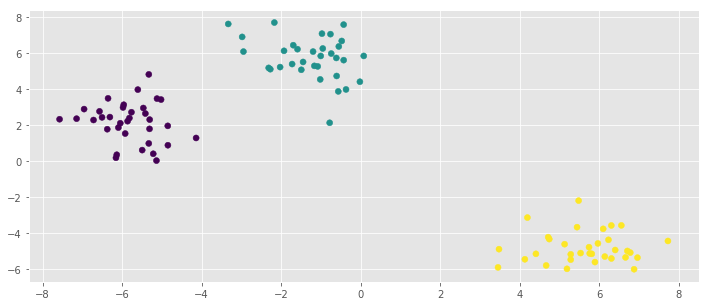

In [89]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

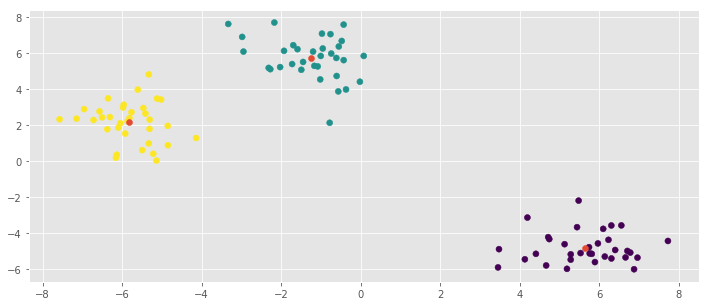

In [57]:
## Работоспособность MyKmeans
km = MyKmeans(k=3)
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


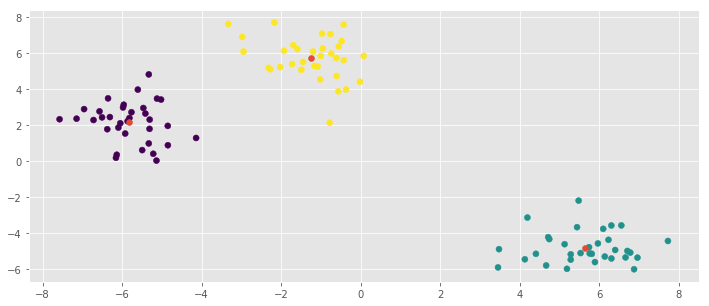

In [58]:
## Работоспособность MyKmeans++
km = MyKmeans(k=3, init='k-means')
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:,0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])

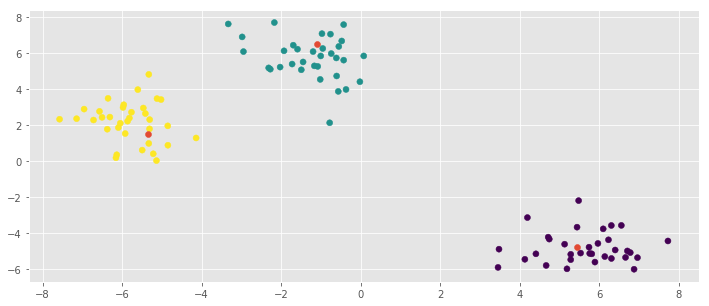

In [59]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
km = MiniBatchKMeans(k=3)
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


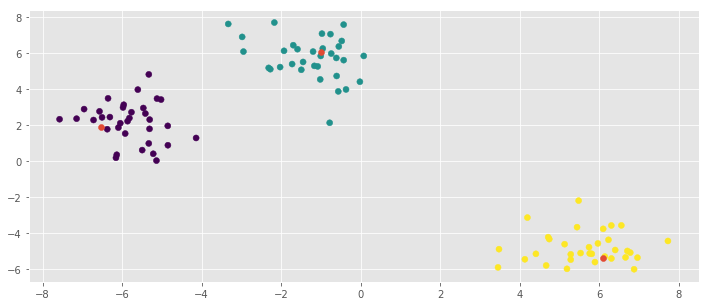

In [60]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
km = MiniBatchKMeans(k=3, init='k-means')
km.fit(X)
y_pred = km.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(km.centroids[:, 0], km.centroids[:, 1])


Text(0,0.5,'time')

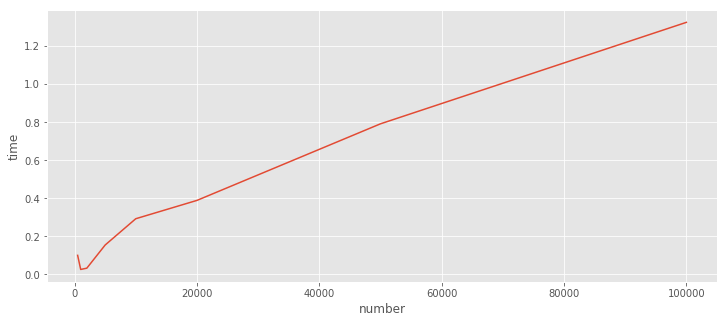

In [61]:
## Время выполнения алгоритма Kmeans из sklearn
import time
from sklearn.cluster import KMeans
sizes = [
    500,
    1000,
    2000,
    5000,
    10000,
    20000,
    50000,
    100000,
    ]
t1 = np.empty(len(sizes))
for (i, s) in enumerate(sizes):
    (X, y) = make_blobs(
        n_samples=s,
        n_features=2,
        centers=3,
        cluster_std=1,
        center_box=(-10.0, 10.0),
        shuffle=False,
        random_state=123,
        )
    km = KMeans(n_clusters=3)
    tau = time.time()
    km.fit(X)
    t1[i] = time.time() - tau
plt.plot(sizes, t1)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

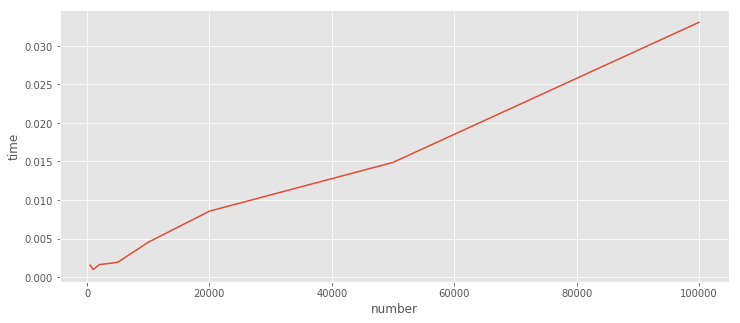

In [63]:
## Время выполнения алгоритма MyKmeans
t2 = np.empty(len(sizes))
for (i, s) in enumerate(sizes):
    (X, y) = make_blobs(
        n_samples=s,
        n_features=2,
        centers=3,
        cluster_std=1,
        center_box=(-10.0, 10.0),
        shuffle=False,
        random_state=123,
        )
    km = MyKmeans(k=3, max_iter=300)
    tau = time.time()
    km.fit(X)
    t2[i] = time.time() - tau
plt.plot(sizes, t2)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

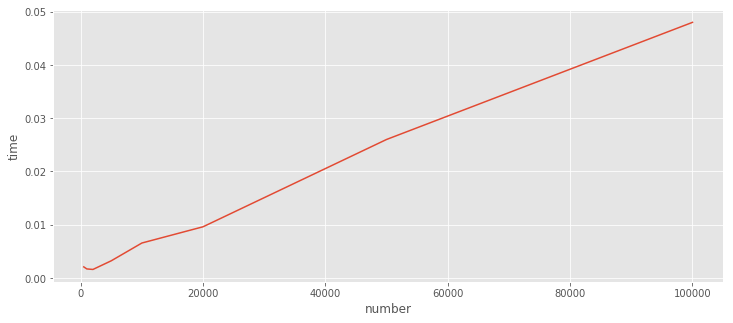

In [64]:
## Время выполнения алгоритма MyKmeans++
t3 = np.empty(len(sizes))
for (i, s) in enumerate(sizes):
    (X, y) = make_blobs(
        n_samples=s,
        n_features=2,
        centers=3,
        cluster_std=1,
        center_box=(-10.0, 10.0),
        shuffle=False,
        random_state=123,
        )
    km = MyKmeans(k=3, max_iter=300, init='k-means')
    tau = time.time()
    km.fit(X)
    t3[i] = time.time() - tau
plt.plot(sizes, t3)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

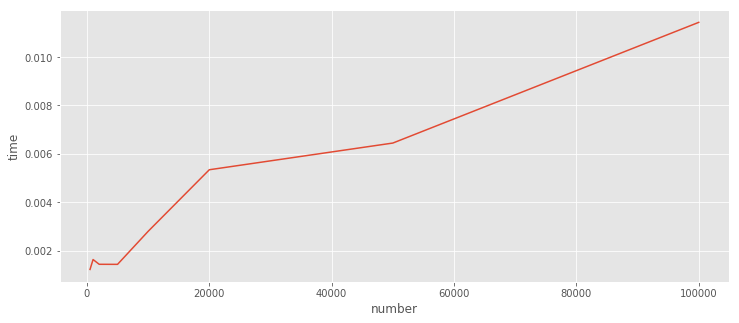

In [69]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans

t4 = np.empty(len(sizes))
for (i, s) in enumerate(sizes):
    (X, y) = make_blobs(
        n_samples=s,
        n_features=2,
        centers=3,
        cluster_std=1,
        center_box=(-10.0, 10.0),
        shuffle=False,
        random_state=123,
        )
    km = MiniBatchKMeans(k=3, max_iter=300, batch_size=100)
    tau = time.time()
    km.fit(X)
    t4[i] = time.time() - tau
plt.plot(sizes, t4)
plt.xlabel('number')
plt.ylabel('time')


Text(0,0.5,'time')

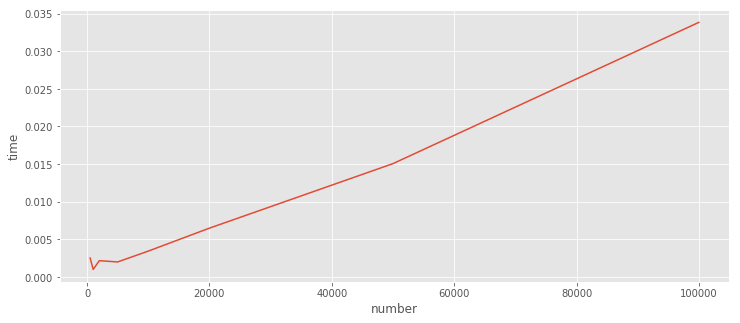

In [71]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
t5 = np.empty(len(sizes))
for (i, s) in enumerate(sizes):
    (X, y) = make_blobs(
        n_samples=s,
        n_features=2,
        centers=3,
        cluster_std=1,
        center_box=(-10.0, 10.0),
        shuffle=False,
        random_state=123,
        )
    km = MiniBatchKMeans(k=3, max_iter=300, init='k-means',
                         batch_size=100)
    tau = time.time()
    km.fit(X)
    t5[i] = time.time() - tau
plt.plot(sizes, t5)
plt.xlabel('number')
plt.ylabel('time')

Text(0,0.5,'time')

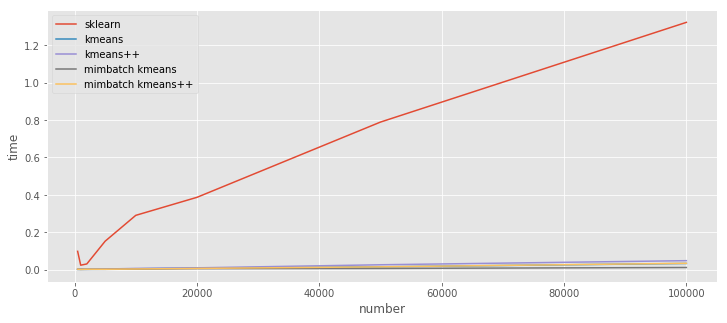

In [74]:
plt.plot(sizes, t1, label='sklearn')
plt.plot(sizes, t2, label='kmeans')
plt.plot(sizes, t3, label='kmeans++')
plt.plot(sizes, t4, label='mimbatch kmeans')
plt.plot(sizes, t5, label='mimbatch kmeans++')
plt.legend()
plt.xlabel('number')
plt.ylabel('time')

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [75]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [83]:
%%time
## MyKMeans

km = MyKmeans(k=k)
km.fit(X)
for (i, centr) in enumerate(km.centroids):
    print (words[np.argsort(centr)[-5:]], km.labels[km.labels
           == i].size)


Index(['volleyball', 'basketball', 'baseball', 'sports', 'football'], dtype='object') 775
Index(['mall', 'dance', 'shopping', 'dress', 'church'], dtype='object') 3113
Index(['drugs', 'rock', 'sex', 'kissed', 'hair'], dtype='object') 948
Index(['volleyball', 'death', 'softball', 'soccer', 'basketball'], dtype='object') 293
Index(['volleyball', 'tennis', 'marching', 'blonde', 'softball'], dtype='object') 20085
Index(['shopping', 'hollister', 'swimming', 'football', 'soccer'], dtype='object') 1340
Index(['cute', 'bible', 'jesus', 'sexy', 'god'], dtype='object') 431
Index(['hair', 'drunk', 'death', 'drugs', 'die'], dtype='object') 2792
Index(['hair', 'mall', 'cute', 'shopping', 'dress'], dtype='object') 223
CPU times: user 87.1 ms, sys: 1.66 ms, total: 88.8 ms
Wall time: 115 ms


In [84]:
%%time
## MyKMeans++
km = MyKmeans(k=k, init='k-means')
km.fit(X)
for (i, centr) in enumerate(km.centroids):
    print (words[np.argsort(centr)[-5:]], km.labels[km.labels
           == i].size)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in less


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [85]:
%%time
## MyKMeans с MiniBatchMyKMeans

km = MiniBatchKMeans(k=k, batch_size=batch_size)
km.fit(X)
for (i, centr) in enumerate(km.centroids):
    print (words[np.argsort(centr)[-5:]], km.labels[km.labels
           == i].size)


Index(['football', 'rock', 'music', 'band', 'marching'], dtype='object') 347
Index(['soccer', 'jesus', 'sexy', 'tennis', 'blonde'], dtype='object') 21153
Index(['sexy', 'dress', 'mall', 'hot', 'cute'], dtype='object') 450
Index(['baseball', 'dance', 'church', 'jesus', 'bible'], dtype='object') 253
Index(['death', 'cute', 'church', 'shopping', 'mall'], dtype='object') 1350
Index(['sports', 'volleyball', 'basketball', 'god', 'softball'], dtype='object') 433
Index(['music', 'church', 'baseball', 'rock', 'football'], dtype='object') 2672
Index(['hollister', 'volleyball', 'sports', 'abercrombie', 'basketball'], dtype='object') 2625
Index(['die', 'kissed', 'drunk', 'hair', 'drugs'], dtype='object') 717
CPU times: user 51.1 ms, sys: 0 ns, total: 51.1 ms
Wall time: 60.8 ms


In [86]:
%%time
## MyKMeans++ с MiniBatchMyKMeans

km = MiniBatchKMeans(k=k, batch_size=batch_size, init='k-means')
km.fit(X)
for (i, centr) in enumerate(km.centroids):
    print (words[np.argsort(centr)[-5:]], km.labels[km.labels
           == i].size)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in less


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in true_divide


Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 30000
Index(['drunk', 'cheerleading', 'soccer', 'god', 'softball'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
Index(['hot', 'kissed', 'dance', 'drunk', 'drugs'], dtype='object') 0
CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.46 s


In [0]:
## Вывод
k-means++ проигрывает по скорости обычному k-means
MiniBatch k-means работает быстрее, чем обычный k-means
k-means и k-means с MiniBatch дают одну и туже точность, но k-means с MiniBatch быстрее, чем обычный k-means
Мой вывод использовать k-means с MiniBatch - это наилучший вариант 